In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Regression model
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

#metrices
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd. read_csv("bangladesh_student_performance_2018.csv")
df

,date,gender,age,address,famsize,Pstatus,M_Edu,F_Edu,M_Job,F_Job,relationship,smoker,tuition_fee,time_friends,ssc_result,hsc_result
0,29/04/2018,M,18,Rural,GT3,Together,3,2,At_home,Farmer,No,No,71672,4,4.22,3.72
1,29/04/2018,F,19,Rural,LE3,Apart,0,4,Other,Health,Yes,No,26085,5,3.47,2.62
2,29/04/2018,F,19,Rural,GT3,Together,0,3,Teacher,Services,No,No,40891,3,3.32,2.56
3,29/04/2018,F,19,Rural,LE3,Apart,2,3,At_home,Business,No,No,50600,2,4.57,4.17
4,29/04/2018,M,17,Rural,GT3,Together,1,1,At_home,Farmer,No,No,62458,2,4.50,3.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,29/04/2018,M,18,Urban,GT3,Together,2,2,Teacher,Health,No,No,108426,2,3.57,3.18
2014,29/04/2018,M,19,Urban,GT3,Together,0,3,Other,Teacher,Yes,No,100665,5,4.05,3.13
2015,29/04/2018,M,18,Urban,GT3,Together,3,2,Services,Farmer,Yes,No,92291,1,3.93,3.15
2016,29/04/2018,M,19,Rural,GT3,Together,0,2,At_home,Teacher,No,No,43926,3,3.34,2.83


In [3]:
len(df.columns)

16

In [4]:
len(df)

2018

In [5]:
# simply columns
df.columns= [
    'date','st_gender','st_age','st_address',
    'st_fam_size','pstatus','m_edu','f_edu',
    'm_job','f_job','st_relationship',
    'smoker','tuition_fee','time_with_friends',
    'ssc_result','hsc_result'
]

In [6]:
df.columns.size

16

In [7]:
# drop data
if 'date' in df.columns:
  df.drop( columns = ['date'], inplace=True )

In [8]:
df.columns.size

15

In [9]:
df.shape 

(2018, 15)

In [10]:
#  Correlatin for Numerical Value
corr_target = df.select_dtypes(include=np.number).corr()['hsc_result'].sort_values(ascending=False)
print(corr_target)

hsc_result           1.000000
ssc_result           0.950178
m_edu                0.063776
f_edu                0.054811
tuition_fee          0.038068
st_age              -0.009857
time_with_friends   -0.156356
Name: hsc_result, dtype: float64


In [11]:
# Separate X and y
X = df.drop('hsc_result',axis=1)
y = df['hsc_result']

In [12]:
# Numerical Column and Categorical Columns
numeric_features = X.select_dtypes(include = ['int64','float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

In [13]:
numeric_features

Index(['st_age', 'm_edu', 'f_edu', 'tuition_fee', 'time_with_friends',
       'ssc_result'],
      dtype='object')

In [14]:
categorical_features

Index(['st_gender', 'st_address', 'st_fam_size', 'pstatus', 'm_job', 'f_job',
       'st_relationship', 'smoker'],
      dtype='object')

In [15]:
# pipeline 
# #for numerical features

num_transformer = Pipeline (
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [16]:
# categorical feature
cat_transformer = Pipeline( steps = [
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
] )

In [17]:
preprocessor = ColumnTransformer(
    transformers= [
        ('num',num_transformer,numeric_features),
        ('cat',cat_transformer,categorical_features)
    ]
    )

In [18]:
# split
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state=42)

In [19]:
reg_lr = LinearRegression()
reg_rf = RandomForestRegressor( n_estimators=100, random_state=42 )
reg_gb = GradientBoostingRegressor( n_estimators=100 , random_state=42 )

In [20]:
#Voting regressor

voting_reg = VotingRegressor(
    estimators= [
        ('lr', reg_lr),
        ('rf',reg_rf),
        ('gb', reg_gb)
    ]
)

In [21]:
#stacking

stacking_reg = StackingRegressor(
    estimators= [
        ('rf',reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator= Ridge() #the meta learner
)

In [22]:
# Model training
#dictionary of all model
model_to_train = {
    'Linear Regression' : reg_lr,
    'Random Forest' : reg_rf,
    'Gradient Boosting': reg_gb,
    'Voting Ensemble ' : voting_reg,
    'Stacking Ensemble ' : stacking_reg

}

In [ ]:
#training & Evaluation

result = []

for name , model in model_to_train.items():
  pipe = Pipeline(
      [
          ('preprocessor', preprocessor),
          ('model',model)
      ]
  )

  #train

  pipe.fit(X_train,y_train)

  #predict

  y_pred = pipe.predict(X_test)

  #Evaluate

  r2 = r2_score(y_test,y_pred)
  rmse = np.sqrt(mean_squared_error(y_test,y_pred))
  mae = mean_absolute_error(y_test,y_pred)

  result.append({
      "Model": name,
      "R2 Score" :r2,
      "RMSE": rmse,
      "MAE" : mae
  })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)

print(results_df)

                Model  R2 Score      RMSE       MAE
4  Stacking Ensemble   0.959572  0.123097  0.098685
2   Gradient Boosting  0.959565  0.123107  0.098902
3    Voting Ensemble   0.957545  0.126144  0.100820
1       Random Forest  0.950226  0.136586  0.108121
0   Linear Regression  0.945920  0.142371  0.111376


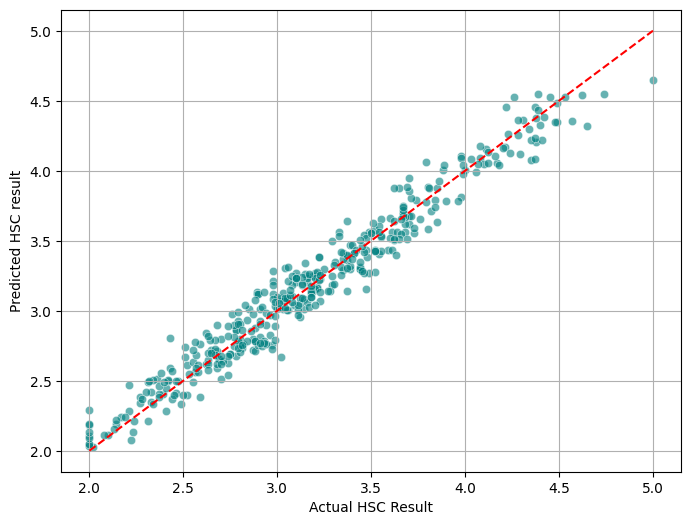

In [24]:
best_model_name = results_df.iloc[0]['Model']
best_model_obj = model_to_train[best_model_name]


#fit the best model

final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model',best_model_obj)
])

final_pipe.fit(X_train,y_train)
y_final_pred = final_pipe.predict(X_test)


#plot Actual vs predicted

plt.figure( figsize = (8,6) )

sns.scatterplot(x=y_test, y=y_final_pred, alpha = 0.6, color='teal' )
plt.plot( [2,5] , [2,5], color = "red", linestyle = '--'  )

plt.xlabel("Actual HSC Result")
plt.ylabel("Predicted HSC result")

plt.grid(True)
plt.show()

In [26]:
from sklearn.model_selection import cross_val_score
rf_pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('model',RandomForestRegressor(n_estimators=100,random_state=42))

     ]

  )

In [27]:
# 5 fold cv

cv_scores = cross_val_score( rf_pipeline,X_train,y_train,cv=5, scoring='neg_mean_squared_error' )
cv_rmse = np.sqrt(-cv_scores)

print(cv_rmse)

[0.13830308 0.14217329 0.15353661 0.14769885 0.12948439]


In [28]:
print(cv_rmse.mean())

0.14223924182767875


In [29]:
print(cv_rmse.std())

0.008192946913993493


In [30]:
stacking_pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('model',stacking_reg)

     ]

  )

In [31]:
cv_scores = cross_val_score(
    stacking_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs = -1 #use all processor core , to speed it up
    )

stacking_rmse = np.sqrt(-cv_scores)

print(stacking_rmse)

[0.12744945 0.13429247 0.13333103 0.13390772 0.11927792]


In [32]:
rf_pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('model',RandomForestRegressor(n_estimators=100,random_state=42))

     ]

  )

In [33]:
#define the grid

param_grid = {
    'model__n_estimators' : [100,200] ,
    'model__max_depth': [None,10,20],
    'model__min_samples_split' : [2,5]
}

In [34]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator = rf_pipeline,
    param_grid = param_grid,
    cv = 5 ,
    scoring = 'neg_root_mean_squared_error',
    n_jobs =-1,
    verbose = 2

)

In [35]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['st_age', 'm_edu', 'f_edu', 'tuition_fee', 'time_with_friends',
       'ssc_result'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['st_gender', 'st_address', 'st_fam_size', 'pstatus', 'm_job', 'f_job',
       'st_relationship', 'smoker'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [36]:
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.14143574368260858
{'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}


In [37]:
from scipy.stats import randint

my_dist = randint(1,10)

print(my_dist.rvs())
print(my_dist.rvs())
print(my_dist.rvs(size=5))

3
7
[7 5 5 2 4]


In [38]:
param_dist = {
    'model__n_estimators' : randint(100,500) ,
    'model__max_depth': [None,10,20],
    'model__min_samples_split' : randint(1,10)
}

In [39]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator = rf_pipeline,
    param_distributions = param_dist,
    n_iter=1,
    cv = 5 ,
    scoring = 'neg_root_mean_squared_error',
    n_jobs =-1,
    verbose = 2,
    random_state = 42
)

In [40]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['st_age', 'm_edu', 'f_edu', 'tuition_fee', 'time_with_friends',
       'ssc_result'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy=...
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 10, 20],
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000203715374D0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000203715356D0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [41]:
print( -random_search.best_score_ )
print( random_search.best_params_ )

0.14083361680988907
{'model__max_depth': 20, 'model__min_samples_split': 4, 'model__n_estimators': 448}


In [42]:
import pickle
from sklearn.linear_model import LinearRegression

X_train_lr = [ [1],[2],[3],[4],[5] ]  #study
y_train_lr = [10,20,30,40,50] #marks

model = LinearRegression()

model.fit(X_train_lr,y_train_lr)

LinearRegression()

In [43]:
model.predict( [ [6] ] )[0]

np.float64(59.99999999999999)